# ECE 364 Lecture 19
## Deep Nets (Part 1): Multi-layer Perceptrons
### Learning objectives
After this lecture, students should be able to
* Explain how non-linear activation functions allow the creation of more complex multi-layer machine learning models.
* Describe the construction of multi-layer perceptrons and the representation of intermediate features.
* Create multi-layer perceptrons in PyTorch and train these models on a provided dataset.

## Limitations of Logistic Regression

We have demonstrated how logistic regression paired with the softmax function enables us to perform multi-class classification. Through toy datasets in the previous lectures and the MNIST dataset in the homework, we have shown that logistic regression is highly effective in many problem settings. Recall that we can define a multi-class logistic regression model as performing a matrix-vector multiplication with an input vector $x\in\mathbb{R}^N$ to produce class scores $z\in\mathbb{R}^M$.

$$
\begin{align}
z &= Wx+b\\
&= \begin{bmatrix}
\rule[.6ex]{4ex}{0.75pt} & w_1^\top & \rule[.6ex]{4ex}{0.75pt}\\
\rule[.6ex]{4ex}{0.75pt} & w_2^\top & \rule[.6ex]{4ex}{0.75pt}\\
& \vdots & \\
\rule[.6ex]{4ex}{0.75pt} & w_M^\top & \rule[.6ex]{4ex}{0.75pt}\\
\end{bmatrix}\begin{bmatrix}
\rule[-1ex]{0.5pt}{4ex}\\
x\\
\rule[1ex]{0.5pt}{4ex}\\
\end{bmatrix}
+\begin{bmatrix}
b_1\\
b_2\\
\vdots\\
b_M
\end{bmatrix}\\
&= \begin{bmatrix}
z_1\\
z_2\\
\vdots\\
z_M
\end{bmatrix}
\end{align}
$$

In PyTorch, we can efficiently implement the multi-class logistic regression model using the [``nn.Linear`` class](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) which implements parameter matrices including bias terms. The resulting class scores are then converted to class probabilities using the softmax function.

$$
\textrm{softmax}(z)_k=\mathbf{Pr}\{\textrm{Class }y=k|x\} = \frac{e^{z_k}}{\sum_{j=1}^{M}e^{z_j}}.
$$

Let's now consider another toy dataset known as the two moons dataset and see how logistic regression performs on this data.

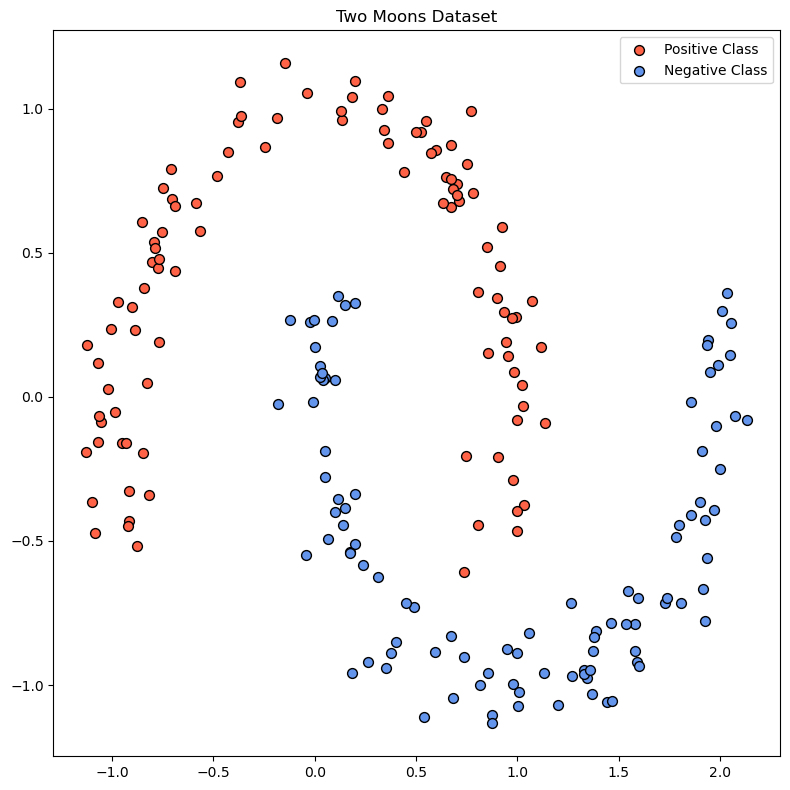

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

class TwoMoonsDataset(Dataset):
    def __init__(self, sigma, N):
        self.sigma = sigma
        self.N = N
        self.radius = 1
        self.angle_offset = -np.pi/8
        self.positive_center = torch.tensor([0, 0])
        self.negative_center = torch.tensor([1, 0])
        # generate angles of each moon
        positive_angles = torch.rand(N)*(np.pi-2*self.angle_offset)+self.angle_offset
        negative_angles = torch.rand(N)*(np.pi-2*self.angle_offset)+self.angle_offset
        # generate each moon
        self.positive_data = self.positive_center + torch.stack((self.radius*torch.cos(positive_angles),
                                                                 self.radius*torch.sin(positive_angles)), dim=-1)
        self.positive_data = self.positive_data + torch.randn(N, 2)*sigma
        self.negative_data = self.negative_center + torch.stack((self.radius*torch.cos(-negative_angles),
                                                                 self.radius*torch.sin(-negative_angles)), dim=-1)
        self.negative_data = self.negative_data + torch.randn(N, 2)*sigma
        # wrap up all data and labels
        self.data = torch.cat((self.positive_data, self.negative_data), dim=0)
        self.labels = torch.cat((torch.ones(N), torch.zeros(N))).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class MulticlassLogisticRegression(nn.Module):
    def __init__(self, N, M):
        super().__init__()
        self.N = N # input dimension
        self.M = M # number of classes
        self.weight_matrix = nn.Linear(N, M, bias=True) # N input dimensions, M output dimensions

    def forward(self, x):
        return self.weight_matrix(x)

def plot_model_probs(model, plus_class, negative_class):
    x = torch.linspace(-2, 3, 100)
    y = torch.linspace(-2, 2, 100)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    meshgrid_inputs = torch.stack((X.flatten(), Y.flatten()), dim=1)
    with torch.no_grad():
        meshgrid_outputs = torch.softmax(model(meshgrid_inputs), dim=1)[:, 1]

    plt.figure(figsize=(8, 6))
    plt.contourf(X.numpy(), Y.numpy(), meshgrid_outputs.reshape(100, 100).numpy(), cmap='RdBu_r', levels=100)
    plt.colorbar()
    plt.title('Probability of positive class')
    plt.scatter(plus_class[:, 0].numpy(), plus_class[:, 1].numpy(), color='tomato', s=50, edgecolor='black')
    plt.scatter(negative_class[:, 0].numpy(), negative_class[:, 1].numpy(), color='cornflowerblue', s=50, edgecolor='black')
    plt.axis(False)
    plt.tight_layout()
    
def multiclass_model_accuracy(model, input_data, labels):
    predictions = model(input_data) # no need to squeeze/unsqueeze dimensions now!
    predicted_classes = torch.argmax(predictions, dim=1) # find highest scoring class along the columns
    n_correct = torch.sum(torch.eq(predicted_classes, labels))
    return n_correct


# visualize example of two moons dataset
N = 100
sigma = 0.1
dataset = TwoMoonsDataset(sigma, N)
plus_data = dataset.positive_data
negative_data = dataset.negative_data
plt.figure(figsize=(8, 8))
plt.scatter(plus_data[:, 0].numpy(), plus_data[:, 1].numpy(), color='tomato', s=50, edgecolor='black', label='Positive Class')
plt.scatter(negative_data[:, 0].numpy(), negative_data[:, 1].numpy(), color='cornflowerblue', s=50, edgecolor='black', label='Negative Class')
plt.title('Two Moons Dataset')
plt.legend()
plt.tight_layout()

Now, let's try training a logistic regression model on this data. For the purposes of this exercise, we will not worry about creating separate training, validation, and testing splits.

Text(0, 0.5, 'Accuracy')

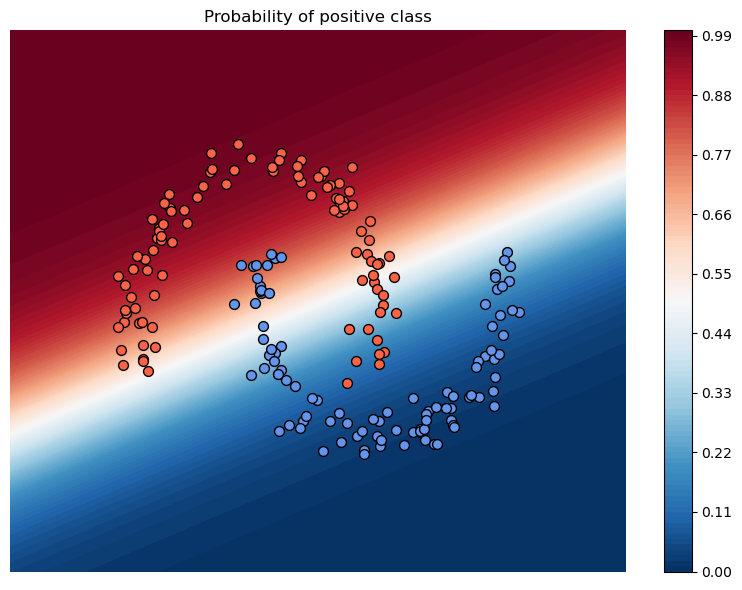

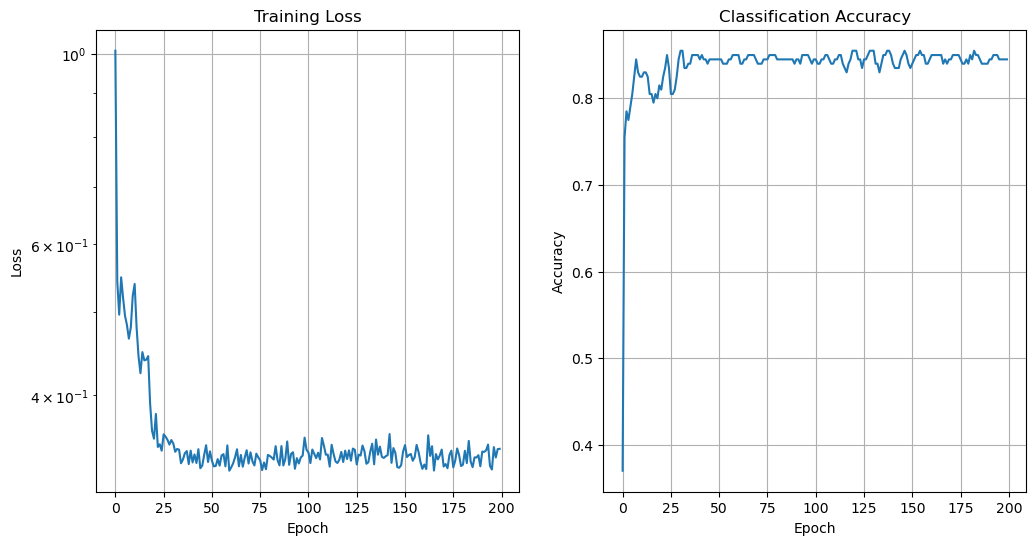

In [3]:
# loss function, model, and optimizer
criterion = nn.CrossEntropyLoss(reduction='mean') # cross-entropy loss, use mean of loss
lr = 1e-2 # learning rate
M = 2 # two classes
N = 2 # data is two-dimensional
model = MulticlassLogisticRegression(M, N)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-3) 

# create training dataloader
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# training loop
n_epoch = 200
loss_values, accuracies = [], []
for n in range(n_epoch):
    epoch_loss, epoch_acc = 0, 0
    for x_batch, y_batch in train_loader:
        # zero out gradients
        optimizer.zero_grad()
        # pass batch to model
        predictions = model(x_batch)
        # calculate loss
        loss = criterion(predictions, y_batch)
        # backpropagate and update
        loss.backward() # backprop
        optimizer.step()
        # logging to update epoch_loss (add loss value) and epoch_acc (add current batch accuracy)
        epoch_loss += loss.item()
        epoch_acc += multiclass_model_accuracy(model, x_batch, y_batch)
    loss_values.append(epoch_loss/len(train_loader))
    accuracies.append(epoch_acc/len(dataset))
    
# plot model probabilities
plot_model_probs(model, dataset.positive_data, dataset.negative_data)
# plot loss values
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.grid(True)
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

The provided two moons dataset is clearly separable by some curvy line, thus we should be able to find some representation for the class boundary that perfectly separates the two classes. However, logistic regression is incapable of performing this separation because the weights of a logistic regression model parameterize a straight line or hyperplane class boundary. In other words, we can only achieve linear class boundaries with logistic regression while this toy dataset requires a non-linear class boundary.

## How can we represent more complex functions?

The above examples motivates the need to provide more complexity or **representational capacity** to the logistic regression model. Thus far, logistic regression has a single weight matrix (including the bias term) to produce class scores:
$$
z = Wx.
$$
Thus, for input dimension $N$ and number of classes $M$, we have $N\times M + M=M(N+1)$ learnable parameters. For example, the above 2D logistic regression model only has six trainable parameters. How can we increase the number of parameters and thus the complexity of our classifier?

One possible solution is to perform two matrix multiplications where the first weight matrix embeds the input vector into a higher-dimensional vector space then the second weight matrix reduces the dimension back down to the number of classes. Concretely, let $W_1\in\mathbb{R}^{L\times N}$ and $W_2\in\mathbb{R}^{M\times L}$ be two weight matrices.

$$
\begin{align}
z_1 &= W_1x\in\mathbb{R}^{L}\\
z_2 &= W_2z_1\in\mathbb{R}^{M}
\end{align}
$$

Including bias terms, we will now have $L(N+1)+M(L+1)$ parameters; clearly, many more than before if we increase $L$. The first weight matrix contains many parameters that move $x$ from $\mathbb{R}^N$ to $\mathbb{R}^L$ to form $z_1$; then, the second weight matrix moves $z_1$ from $\mathbb{R}^{L}$ back to $\mathbb{R}^M$ to form the final class scores in $z_2$. Altogether, we have

$$
z_2 = W_2W_1x.
$$

This idea of creating additional parameter matrices is *almost correct* in practice. However, consider that the composition of two linear operators/functions, e.g. $W_1$ and $W_2$, also results in a linear function. Thus,
$$
\begin{align}
z_2 &= W_2W_1x\\
&= Wx,
\end{align}
$$
where $W=W_2W_1$. This proposed solution only factorizes the original parameter matrix $W$ into two other matrices, but we are close to a good solution to our problem! What if instead, we broke up the linearity of multiplying these matrices by injecting a simple element-wise non-linear function?

Let $\textrm{ReLU}(z)$ denote the **rectified linear unit** (ReLU) function where
$$
\textrm{ReLU}(z)=\max\{0, z\}
$$
simply thresholds negative numbers to zero. This function is non-linear and allows us to create a now function:
$$
f(x) = z = W_2\textrm{ReLU}(W_1x).
$$
The non-linear ReLU function prevents the two weight matrices from combining into one linear operator and thus we have effectively increased the number of unique parameters our classifier may learn! In fact, for arbitrary non-linear element-wise function $\sigma(z)$, we may stack many **layers** of parameter matrices.
$$
f(x) = z = W_K\sigma(W_{K-1}(\cdots\sigma(W_2\sigma(W_1x)))))
$$

Let's try making a two-layer model to improve upon the logistic regression model for the above two moons dataset.

Text(0, 0.5, 'Accuracy')

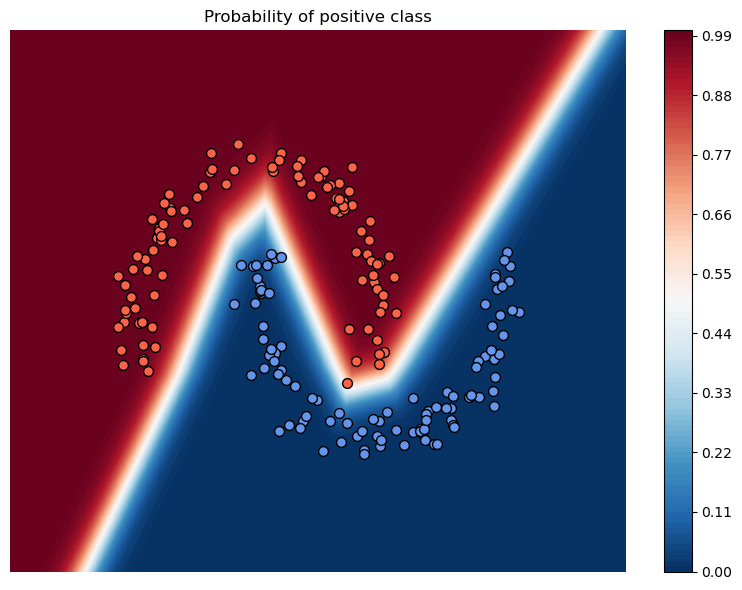

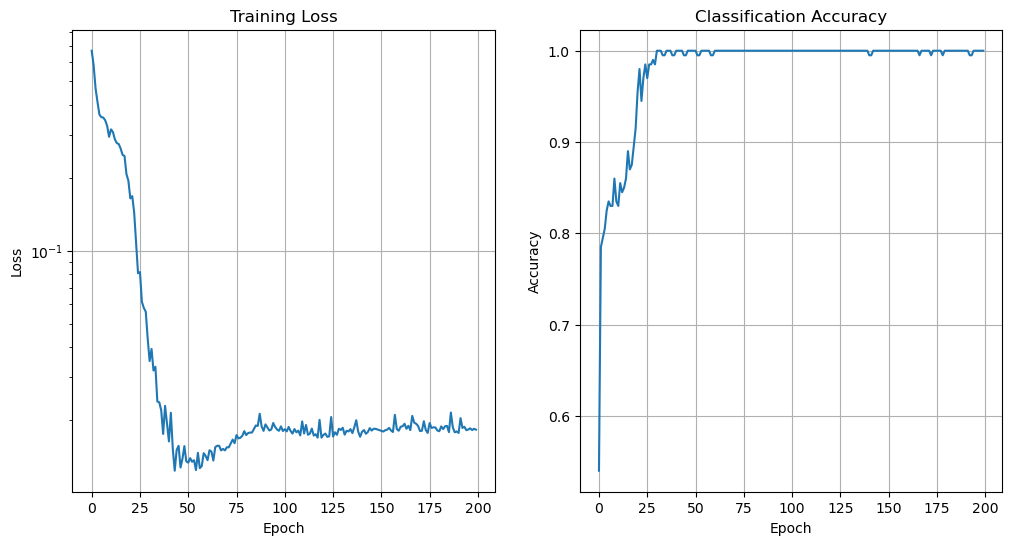

In [4]:
class TwoLayerModel(nn.Module):
    def __init__(self, N, L, M):
        super().__init__()
        self.N = N # input dimension
        self.M = M # number of classes
        self.weight_matrix1 = nn.Linear(N, L, bias=True) # N input dimensions, L hidden dimensions
        self.weight_matrix2 = nn.Linear(L, M)

    def forward(self, x):
        x = self.weight_matrix1(x)
        x = torch.nn.functional.relu(x)
        z = self.weight_matrix2(x)
        return z

# loss function, model, and optimizer
criterion = nn.CrossEntropyLoss(reduction='mean') # cross-entropy loss, use mean of loss
lr = 1e-2 # learning rate
M = 2 # two classes
N = 2 # data is two-dimensional
L = 8 # number of hidden features
fancy_new_model = TwoLayerModel(N, L, M)
optimizer = torch.optim.SGD(fancy_new_model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-3) 

# create training dataloader
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# training loop
n_epoch = 200
loss_values, accuracies = [], []
for n in range(n_epoch):
    epoch_loss, epoch_acc = 0, 0
    for x_batch, y_batch in train_loader:
        # zero out gradients
        optimizer.zero_grad()
        # pass batch to model
        predictions = fancy_new_model(x_batch)
        
        # calculate loss
        loss = criterion(predictions, y_batch)
        # backpropagate and update
        loss.backward() # backprop
        optimizer.step()
        # logging to update epoch_loss (add loss value) and epoch_acc (add current batch accuracy)
        epoch_loss += loss.item()
        epoch_acc += multiclass_model_accuracy(fancy_new_model, x_batch, y_batch)
    loss_values.append(epoch_loss/len(train_loader))
    accuracies.append(epoch_acc/len(dataset))
    
# plot model probabilities
plot_model_probs(fancy_new_model, dataset.positive_data, dataset.negative_data)
# plot loss values
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.grid(True)
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## Activation Functions

We commonly refer to these element-wise non-linearities as **activation functions**. Examples of activation functions, including ReLU, are as follows:

* [Rectified Linear Unit (ReLU)](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU):
$$
\sigma(z) = \begin{cases}
z,~&z\geq 0\\
0,~&z<0
\end{cases}=\max\{0, z\}
$$
* [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid):
$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$
* [Hyperbolic Tangent (Tanh)](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh):
$$
\sigma(z) = \frac{e^z-e^{-z}}{e^{z}+e^{-z}}
$$
* [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU)
$$
\sigma_\tau(z) = \begin{cases}
z,~&z\geq 0\\
-\tau z~&z < 0
\end{cases}
$$
* and many more may be [found here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

## Multi-layer Perceptron

The model we created above is known as a two-layer perceptron. One individual weight matrix that transforms an input vector to another vector is commonly referred to as a **perceptron**. The concatenation of multiple perceptrons separated by non-linear activation functions is known as a **multi-layer perceptron** (MLP) or **fully-connected network** (we will skip the abbreviation since FCN is commonly used for something else in machine learning).

Multi-layer perceptrons are our first example of a **deep neural network** or **deep net** in this course! As mentioned earlier, we may stack arbitrarily many perceptrons and non-linearities to form deeper neural nets. Each **layer** has an input and output dimension that is a **hyperparameter** of the **model architecture**. Every layer that is followed by an activation function is referred to as a **hidden layer** as it separates the inputs from the outputs of the model. The below figure depicts a three-layer MLP with two hidden layers. Each arrow represents a weight multiplying one entry of an input vector. The result of this multiplication is passed to a node in the next layer where the result at each node is the summation of all incoming arrows followed by an activation function.

<div>
<center><img src="mlp-figure.jpg" width="800"/> </center>
</div>

Let's create another example MLP.

In [5]:
class FourLayerMLP(nn.Module):
    def __init__(self, input_dim, h1, h2, h3, output_dim, activation_fn):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1) # first fully-connected layer
        self.fc2 = nn.Linear(h1, h2) # second fully-connected layer
        self.fc3 = nn.Linear(h2, h3) # third fully-connected layer
        self.fc4 = nn.Linear(h3, output_dim) # output layer
        self.activation = activation_fn

    def forward(self, x):
        x = self.activation(self.fc1(x)) # first layer
        x = self.activation(self.fc2(x)) # second layer
        x = self.activation(self.fc3(x)) # third layer
        z = self.fc4(x) # output layer
        return z
        
input_dim = 784
h1 = 128
h2 = 64
h3 = 32
output_dim = 10
activation_fn = nn.Tanh()
model = FourLayerMLP(input_dim, h1, h2, h3, output_dim, activation_fn)
print(model)

FourLayerMLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (activation): Tanh()
)


## Lecture Exercise: Image Classification with MLP

To conclude this lecture, we will experiment with creating MLP models to perform image classification with the [FashionMNIST dataset](https://github.com/zalandoresearch/fashion-mnist). This dataset contains $28\times 28$ grayscale images of clothing sorted into ten classes. We have created a dataset to download the data from the ``torchvision`` package (which you may need to install, as well as the ``tqdm`` package for tracking progress bars during training). We have also provided the necessary training code to train an MLP on FashionMNIST. All you need to do is create your own MLP and experiment with different design choices!

a) Fill in the below ``MyMLPModel()`` class with the parameters you would like for your model. Note that the input dimension and output dimension must be 784 and 10 to match the provided data. The dimension, number of hidden layers, and choice of activation function are up to you!

b) Train your MLP model on FashionMNIST and observe the resulting training loss, training accuracy, and validation accuracy. Try playing around with the number of layers, width of these layers, choice of non-linearity, or the learning algorithm details (i.e. learning rate, momentum, batch size, weight decay) to see the effect on training and model performance.

In [6]:
import torch
import torch.nn as nn

class MyMLPModel(nn.Module):
    # add hidden dimension sizes to constructor as you see fit!
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # create layers using nn.Linear(input_dimension, output_dimension) objects
        self.fc1=nn.Linear(input_dim, 784)
        self.fc2=nn.Linear(784, 256)
        self.fc3=nn.Linear(256, 128)
        self.fc4=nn.Linear(128,64)
        self.fc5=nn.Linear(64, output_dim)
        # assign non-linear activation function to class
        self.activation = nn.ReLU()
    def forward(self, x):
        # implement forward pass
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.fc5(x)
        return
        

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# Define the MLP model
class MyMLPModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyMLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the dataset
class FashionMNIST(Dataset):
    def __init__(self):
        self.data = torchvision.datasets.FashionMNIST(root='./',
                                                      download=True,
                                                      train=True,
                                                      transform=transforms.Compose([transforms.ToTensor()]))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image.reshape(-1), label

# Define the accuracy function
def multiclass_model_accuracy(model, input_data, labels):
    predictions = model(input_data)
    predicted_classes = torch.argmax(predictions, dim=1)
    n_correct = torch.sum(torch.eq(predicted_classes, labels))
    return n_correct.item()

# Set up data
N = 1000
N_train = 600
N_val = 200
N_test = 200
dataset = FashionMNIST()
indices = np.random.choice(np.arange(len(dataset)), size=N, replace=False)
np.random.shuffle(indices)
train_indices = indices[:N_train]
val_indices = indices[N_train:N_train+N_val]
test_indices = indices[N_train+N_val:]

batch_size = 8
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))

# Initialize model
input_dim = 784  # dimension of images after being vectorized
output_dim = 10  # number of classes
model = MyMLPModel(input_dim, output_dim)

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-4)

# Logging info
loss_values, train_accuracies, val_accuracies = [], [], []
n_epoch = 300  # set this value
for n in tqdm(range(n_epoch)):
    epoch_loss, epoch_acc = 0, 0
    for x_batch, y_batch in train_loader:
        # Zero out gradients
        optimizer.zero_grad()
        # Pass batch to model
        predictions = model(x_batch)
        # Calculate loss
        loss = criterion(predictions, y_batch)
        # Backpropagate and update
        loss.backward()
        optimizer.step()
        # Logging to update epoch_loss and epoch_acc
        epoch_loss += loss.item()
        print("the loss is ", (epoch_loss))
        epoch_acc += multiclass_model_accuracy(model, x_batch, y_batch)

    loss_values.append(epoch_loss / len(train_loader))
    train_accuracies.append(epoch_acc / N_train)
    # Validation performance
    val_acc = 0
    for x_batch, y_batch in val_loader:
        # Don't compute gradients since we are only evaluating the model
        with torch.no_grad():
            # Validation batch accuracy
            val_acc += multiclass_model_accuracy(model, x_batch, y_batch)
    val_accuracies.append(val_acc / N_val)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Loss values')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(train_accuracies)
plt.grid(True)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(val_accuracies)
plt.grid(True)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

the loss is  2.3102073669433594
the loss is  4.601970434188843
the loss is  6.886482000350952
the loss is  9.199022054672241
the loss is  11.524675130844116
the loss is  13.82152795791626
the loss is  16.106138944625854
the loss is  18.380045652389526
the loss is  20.687785387039185
the loss is  22.992790699005127
the loss is  25.28901195526123
the loss is  27.566956996917725
the loss is  29.84393072128296
the loss is  32.16006684303284
the loss is  34.4353129863739
the loss is  36.76757740974426
the loss is  39.06014156341553
the loss is  41.314032554626465
the loss is  43.62091827392578
the loss is  45.88754343986511
the loss is  48.25356888771057
the loss is  50.54912567138672
the loss is  52.86886930465698
the loss is  55.156463623046875
the loss is  57.46501088142395
the loss is  59.79478621482849
the loss is  62.16110014915466
the loss is  64.43717503547668
the loss is  66.76234531402588
the loss is  69.00773048400879
the loss is  71.28025197982788
the loss is  73.54998803138733


  0%|          | 1/300 [00:00<01:16,  3.89it/s]

the loss is  145.36418342590332
the loss is  147.56475043296814
the loss is  149.75900053977966
the loss is  151.89746046066284
the loss is  154.16141390800476
the loss is  156.4069881439209
the loss is  158.47669005393982
the loss is  160.64075255393982
the loss is  162.81817412376404
the loss is  165.0650737285614
the loss is  167.2414619922638
the loss is  169.36798644065857
the loss is  2.155485153198242
the loss is  4.349937438964844
the loss is  6.369846820831299
the loss is  8.44395112991333
the loss is  10.681800365447998
the loss is  12.78516149520874
the loss is  14.742348670959473
the loss is  16.632755756378174
the loss is  18.82022976875305
the loss is  21.037951707839966
the loss is  23.09381866455078
the loss is  25.291375160217285
the loss is  27.260485649108887
the loss is  29.41045880317688
the loss is  31.394162774086
the loss is  33.436524748802185
the loss is  35.555575251579285
the loss is  37.60374319553375
the loss is  39.54754376411438
the loss is  41.638228893

  1%|          | 2/300 [00:00<01:15,  3.97it/s]

the loss is  105.3904664516449
the loss is  107.2990825176239
the loss is  109.17191421985626
the loss is  110.57068312168121
the loss is  112.18941140174866
the loss is  114.05545377731323
the loss is  115.71300864219666
the loss is  117.35789859294891
the loss is  118.74229526519775
the loss is  120.0018994808197
the loss is  121.78032851219177
the loss is  123.614661693573
the loss is  125.17549932003021
the loss is  126.86140930652618
the loss is  128.1412092447281
the loss is  129.76807034015656
the loss is  131.28503477573395
the loss is  132.6052130460739
the loss is  133.86825382709503
the loss is  135.43042612075806
the loss is  136.78044390678406
the loss is  138.01580488681793
the loss is  1.6820733547210693
the loss is  2.937279462814331
the loss is  4.473324418067932
the loss is  5.535084009170532
the loss is  6.850241422653198
the loss is  7.977739453315735
the loss is  9.228259682655334
the loss is  10.670905709266663
the loss is  11.71545946598053
the loss is  12.717824

  1%|          | 3/300 [00:00<01:08,  4.32it/s]

the loss is  53.189961314201355
the loss is  55.61591184139252
the loss is  56.884074687957764
the loss is  57.902360677719116
the loss is  59.419440269470215
the loss is  60.4801549911499
the loss is  61.77842926979065
the loss is  63.0868581533432
the loss is  64.09013676643372
the loss is  65.31681835651398
the loss is  67.28975713253021
the loss is  68.40892815589905
the loss is  69.10891056060791
the loss is  70.09835946559906
the loss is  71.03056967258453
the loss is  72.05077743530273
the loss is  73.60615015029907
the loss is  74.47610253095627
the loss is  75.07921850681305
the loss is  75.78959292173386
the loss is  76.28721672296524
the loss is  77.00791186094284
the loss is  78.76842099428177
the loss is  79.65724861621857
the loss is  81.3949898481369
the loss is  83.63985359668732
the loss is  84.43268191814423
the loss is  85.02863997220993
the loss is  85.5925857424736
the loss is  86.19019782543182
the loss is  87.405064702034
the loss is  88.3347053527832
the loss is

  1%|▏         | 4/300 [00:00<01:05,  4.51it/s]

the loss is  50.957888439297676
the loss is  51.58407087624073
the loss is  52.359484389424324
the loss is  53.17132396996021
the loss is  54.229043915867805
the loss is  54.51430253684521
the loss is  55.37811867892742
the loss is  55.7507237046957
the loss is  56.30200682580471
the loss is  58.482585057616234
the loss is  59.00410287082195
the loss is  59.961098060011864
the loss is  61.19182239472866
the loss is  62.04404352605343
the loss is  62.8408914655447
the loss is  63.63254092633724
the loss is  64.66518984735012
the loss is  65.33175919950008
the loss is  66.34701035916805
the loss is  67.03194932639599
the loss is  67.72514049708843
the loss is  68.31158958375454
the loss is  68.68531538546085
the loss is  69.21794511377811
the loss is  70.21048177778721
the loss is  71.00238646566868
the loss is  71.97520269453526
the loss is  73.59003938734531
the loss is  0.8332745432853699
the loss is  1.7496389746665955
the loss is  2.77622789144516
the loss is  3.392342209815979
the 

  2%|▏         | 5/300 [00:01<01:08,  4.31it/s]

the loss is  14.198313266038895
the loss is  15.576232105493546
the loss is  16.278791278600693
the loss is  17.065537005662918
the loss is  17.519452303647995
the loss is  18.17461034655571
the loss is  18.876427859067917
the loss is  19.62420681118965
the loss is  20.344031006097794
the loss is  20.642747312784195
the loss is  21.303904324769974
the loss is  22.597783118486404
the loss is  23.24566552042961
the loss is  24.038564056158066
the loss is  24.94346848130226
the loss is  25.85743173956871
the loss is  26.391767650842667
the loss is  27.11948397755623
the loss is  27.917459815740585
the loss is  28.986631959676743
the loss is  30.427852243185043
the loss is  31.8024944961071
the loss is  32.443207532167435
the loss is  32.85548922419548
the loss is  33.70345517992973
the loss is  34.12699565291405
the loss is  34.67589780688286
the loss is  35.23715755343437
the loss is  35.89122357964516
the loss is  36.26936557888985
the loss is  36.913541465997696
the loss is  37.3855975

  2%|▏         | 6/300 [00:01<01:03,  4.62it/s]

the loss is  16.74544158577919
the loss is  17.690704971551895
the loss is  18.221859723329544
the loss is  19.07770350575447
the loss is  19.320900425314903
the loss is  20.24925921857357
the loss is  21.270771130919456
the loss is  21.881969437003136
the loss is  22.331459149718285
the loss is  23.463923200964928
the loss is  23.849957928061485
the loss is  24.752357348799706
the loss is  25.10767538845539
the loss is  25.86982251703739
the loss is  26.42410536110401
the loss is  27.171980634331703
the loss is  27.57339172065258
the loss is  28.226131185889244
the loss is  29.027008816599846
the loss is  29.73020689189434
the loss is  30.417079016566277
the loss is  30.992621645331383
the loss is  31.372474178671837
the loss is  32.54505990445614
the loss is  33.18438099324703
the loss is  33.618170484900475
the loss is  34.37027822434902
the loss is  35.09260235726833
the loss is  35.50100500881672
the loss is  35.840043768286705
the loss is  36.76765613257885
the loss is  36.947583

  2%|▏         | 7/300 [00:01<01:00,  4.86it/s]

the loss is  18.56150982528925
the loss is  19.442228294909
the loss is  20.11918256431818
the loss is  20.403501845896244
the loss is  20.600307025015354
the loss is  21.262116886675358
the loss is  22.57944367080927
the loss is  22.821691192686558
the loss is  24.846660770475864
the loss is  25.743572391569614
the loss is  26.575334824621677
the loss is  26.832360990345478
the loss is  27.42655647546053
the loss is  28.237992115318775
the loss is  28.93930161744356
the loss is  29.750525303184986
the loss is  30.33166951686144
the loss is  30.784083254635334
the loss is  31.21220488101244
the loss is  32.114029593765736
the loss is  32.551257230341434
the loss is  33.00524125248194
the loss is  34.18146822601557
the loss is  34.55816326290369
the loss is  34.87810421735048
the loss is  36.67383313924074
the loss is  37.21955931931734
the loss is  37.665200747549534
the loss is  38.36298004537821
the loss is  38.783447839319706
the loss is  39.480269350111485
the loss is  40.090173937

  3%|▎         | 8/300 [00:01<00:58,  4.97it/s]

the loss is  24.03234313428402
the loss is  24.845204636454582
the loss is  25.58555130660534
the loss is  26.323698982596397
the loss is  26.7234997600317
the loss is  27.443264529109
the loss is  29.222245380282402
the loss is  30.672520205378532
the loss is  31.082595571875572
the loss is  31.316264778375626
the loss is  31.540379226207733
the loss is  32.71696025133133
the loss is  33.55592602491379
the loss is  34.291659235954285
the loss is  34.90018147230148
the loss is  35.3878390789032
the loss is  35.96413689851761
the loss is  36.41022661328316
the loss is  36.83023703098297
the loss is  36.887390580028296
the loss is  37.173796620219946
the loss is  38.073259856551886
the loss is  38.9809968136251
the loss is  39.944997515529394
the loss is  40.48563977703452
the loss is  40.68020023033023
the loss is  41.500180553644896
the loss is  43.07184846326709
the loss is  43.5852441303432
the loss is  44.12292892858386
the loss is  45.0632914416492
the loss is  45.707721184939146
t

  3%|▎         | 9/300 [00:01<00:58,  4.98it/s]

the loss is  26.897641323506832
the loss is  27.725015126168728
the loss is  28.038049213588238
the loss is  28.652077488601208
the loss is  29.18769656866789
the loss is  29.858936719596386
the loss is  30.447370223701
the loss is  31.19935690611601
the loss is  31.38262490183115
the loss is  31.820414073765278
the loss is  32.78044784814119
the loss is  33.53577584773302
the loss is  33.95647273212671
the loss is  34.46629986912012
the loss is  35.26421747356653
the loss is  36.3832558169961
the loss is  36.66708401590586
the loss is  37.02092791348696
the loss is  37.49341759830713
the loss is  38.2687036767602
the loss is  39.29751465469599
the loss is  39.36296197026968
the loss is  39.679998986423016
the loss is  40.60549282282591
the loss is  40.80166354030371
the loss is  41.18078853935003
the loss is  42.24881210178137
the loss is  42.9702068194747
the loss is  43.49486478418112
the loss is  44.18260058015585
the loss is  44.48001190274954
the loss is  45.046798788011074
the l

  3%|▎         | 10/300 [00:02<01:03,  4.53it/s]

the loss is  15.61516423523426
the loss is  16.410782530903816
the loss is  16.62531265616417
the loss is  17.121128410100937
the loss is  17.229702420532703
the loss is  17.296132057905197
the loss is  18.335226744413376
the loss is  19.528612583875656
the loss is  19.866479247808456
the loss is  20.726019352674484
the loss is  20.866448655724525
the loss is  21.240175619721413
the loss is  21.461592197418213
the loss is  21.925725251436234
the loss is  22.16722470521927
the loss is  22.501449555158615
the loss is  23.1728638112545
the loss is  23.450253158807755
the loss is  24.076158314943314
the loss is  24.342358261346817
the loss is  25.216232925653458
the loss is  25.63129499554634
the loss is  25.83808270096779
the loss is  26.628391176462173
the loss is  26.6867718026042
the loss is  27.06354560703039
the loss is  27.229078121483326
the loss is  27.26901476457715
the loss is  27.435650039464235
the loss is  28.17407165840268
the loss is  28.6507474668324
the loss is  29.110628

  4%|▎         | 11/300 [00:02<01:06,  4.36it/s]

the loss is  0.41162359714508057
the loss is  1.0050182342529297
the loss is  1.5662593245506287
the loss is  2.0742966532707214
the loss is  2.214414566755295
the loss is  2.6322920322418213
the loss is  2.8491847962141037
the loss is  3.2454670518636703
the loss is  3.9076360911130905
the loss is  4.3029163628816605
the loss is  4.909669652581215
the loss is  5.209461227059364
the loss is  5.670035019516945
the loss is  6.211686208844185
the loss is  6.8575791865587234
the loss is  7.402782991528511
the loss is  7.777709022164345
the loss is  8.475454404950142
the loss is  8.649460151791573
the loss is  9.098969236016273
the loss is  9.367028012871742
the loss is  9.81978453695774
the loss is  10.859037056565285
the loss is  11.505582883954048
the loss is  11.892489686608315
the loss is  12.472693458199501
the loss is  13.024955943226814
the loss is  13.688002303242683
the loss is  14.105369672179222
the loss is  14.314411997795105
the loss is  14.646304428577423
the loss is  15.2108

  4%|▍         | 13/300 [00:02<01:01,  4.69it/s]

the loss is  0.21304798126220703
the loss is  0.48220452666282654
the loss is  0.7537326812744141
the loss is  1.4839671850204468
the loss is  1.919300615787506
the loss is  2.3440722227096558
the loss is  2.9857088327407837
the loss is  3.9262856245040894
the loss is  4.433689296245575
the loss is  4.651476174592972
the loss is  5.401661843061447
the loss is  5.980679363012314
the loss is  6.459892600774765
the loss is  6.6576200276613235
the loss is  7.388487592339516
the loss is  7.853868260979652
the loss is  8.634886041283607
the loss is  8.866174697875977
the loss is  9.199527204036713
the loss is  9.560936689376831
the loss is  9.806738510727882
the loss is  10.284153923392296
the loss is  10.359909407794476
the loss is  10.773243330419064
the loss is  11.316042684018612
the loss is  11.681812189519405
the loss is  12.880237720906734
the loss is  13.71442075818777
the loss is  14.06158172339201
the loss is  14.130606561899185
the loss is  14.324360251426697
the loss is  14.82914

  5%|▍         | 14/300 [00:03<00:58,  4.92it/s]

the loss is  3.1472196355462074
the loss is  3.661278046667576
the loss is  4.400722064077854
the loss is  4.787182487547398
the loss is  4.9718629494309425
the loss is  5.730621553957462
the loss is  6.0160514786839485
the loss is  6.095769785344601
the loss is  6.56800615042448
the loss is  7.190831296145916
the loss is  7.7736173793673515
the loss is  8.206211768090725
the loss is  8.392423383891582
the loss is  8.72861611098051
the loss is  9.273650638759136
the loss is  9.611962907016277
the loss is  9.667469054460526
the loss is  10.428270190954208
the loss is  10.904016137123108
the loss is  11.117816433310509
the loss is  11.336245447397232
the loss is  11.498210236430168
the loss is  12.632321283221245
the loss is  12.790381297469139
the loss is  13.101386412978172
the loss is  13.349036231637001
the loss is  13.456835493445396
the loss is  13.75637300312519
the loss is  13.962668403983116
the loss is  14.328408643603325
the loss is  15.299950644373894
the loss is  15.44672715

  5%|▌         | 15/300 [00:03<00:55,  5.11it/s]

the loss is  5.489177614450455
the loss is  6.097696870565414
the loss is  6.820774108171463
the loss is  7.199035942554474
the loss is  7.86373895406723
the loss is  7.943289279937744
the loss is  8.6918443441391
the loss is  9.616058707237244
the loss is  9.79485821723938
the loss is  10.025832906365395
the loss is  10.188672989606857
the loss is  11.115034967660904
the loss is  11.612088918685913
the loss is  12.75180721282959
the loss is  13.003213852643967
the loss is  14.155398696660995
the loss is  15.194023579359055
the loss is  15.745225757360458
the loss is  17.101085513830185
the loss is  17.863532692193985
the loss is  18.588548332452774
the loss is  19.161523908376694
the loss is  19.173566243611276
the loss is  19.62544800993055
the loss is  19.90356411691755
the loss is  20.124679050408304
the loss is  20.210328093729913
the loss is  20.426644033752382
the loss is  20.916868603788316
the loss is  21.180349773727357
the loss is  21.3367732828483
the loss is  21.4191357931

  5%|▌         | 16/300 [00:03<00:57,  4.90it/s]

the loss is  11.104575268924236
the loss is  11.417672239243984
the loss is  12.038398884236813
the loss is  12.622525714337826
the loss is  12.810806058347225
the loss is  13.174657426774502
the loss is  13.552126668393612
the loss is  14.122693143785
the loss is  14.614795349538326
the loss is  15.221839152276516
the loss is  16.098265193402767
the loss is  16.418738149106503
the loss is  16.58519747108221
the loss is  17.04780062288046
the loss is  17.548234961926937
the loss is  17.945483677089214
the loss is  18.45781748741865
the loss is  18.65965934842825
the loss is  18.873326919972897
the loss is  19.20381384342909
the loss is  19.797958306968212
the loss is  20.062602065503597
the loss is  20.223974741995335
the loss is  20.69205979257822
the loss is  21.12350720912218
the loss is  21.587197847664356
the loss is  21.88747639209032
the loss is  22.830503053963184
the loss is  23.072448290884495
the loss is  23.641932047903538
the loss is  24.316925086081028
the loss is  24.546

  6%|▌         | 17/300 [00:03<00:54,  5.20it/s]

the loss is  8.019351720809937
the loss is  8.832356989383698
the loss is  9.183692038059235
the loss is  9.328875973820686
the loss is  10.067238762974739
the loss is  10.548478081822395
the loss is  10.908180430531502
the loss is  11.301201477646828
the loss is  12.06864483654499
the loss is  12.491838231682777
the loss is  12.837654158473015
the loss is  13.16681782901287
the loss is  13.451629742980003
the loss is  13.481498697772622
the loss is  14.063983956351876
the loss is  14.545031229034066
the loss is  14.734505066648126
the loss is  14.989177891984582
the loss is  15.432606736198068
the loss is  15.806233474984765
the loss is  16.368370542302728
the loss is  16.48366547562182
the loss is  16.86288676597178
the loss is  16.93388300575316
the loss is  17.200895542278886
the loss is  17.46472736634314
the loss is  17.519262654706836
the loss is  17.71696743182838
the loss is  17.74199816584587
the loss is  18.06502029299736
the loss is  18.251690477132797
the loss is  18.49588

  6%|▌         | 18/300 [00:03<00:54,  5.15it/s]

the loss is  9.803943414241076
the loss is  9.943832535296679
the loss is  10.231754142791033
the loss is  10.276284985244274
the loss is  11.062106482684612
the loss is  11.235819779336452
the loss is  11.52922486513853
the loss is  11.951842986047268
the loss is  12.177483402192593
the loss is  13.082154713571072
the loss is  13.224079363048077
the loss is  13.281091205775738
the loss is  13.327774301171303
the loss is  13.36908819898963
the loss is  14.014163758605719
the loss is  14.146520536392927
the loss is  14.520387422293425
the loss is  14.739457618445158
the loss is  15.293830763548613
the loss is  15.657816302031279
the loss is  16.366309713572264
the loss is  16.433025736361742
the loss is  16.61271946504712
the loss is  16.77250625565648
the loss is  17.455576796084642
the loss is  17.99303336814046
the loss is  18.14496747031808
the loss is  18.339732352644205
the loss is  18.707916412502527
the loss is  19.003672752529383
the loss is  19.506716702133417
the loss is  19.

  6%|▋         | 19/300 [00:03<00:52,  5.36it/s]

the loss is  12.624148902483284
the loss is  12.66570342425257
the loss is  13.4854309046641
the loss is  14.54345113877207
the loss is  14.64305264595896
the loss is  14.799375646747649
the loss is  14.922367163933814
the loss is  15.024685614742339
the loss is  15.479675554670393
the loss is  16.093009614385664
the loss is  16.410115324892104
the loss is  16.810526960529387
the loss is  16.92205658648163
the loss is  16.99101393762976
the loss is  17.305945270694792
the loss is  17.440202676691115
the loss is  17.564243094064295
the loss is  18.060980365611613
the loss is  18.93968324456364
the loss is  19.574306176044047
the loss is  19.578719947487116
the loss is  19.855497661978006
the loss is  20.08469982817769
the loss is  20.393421102315187
the loss is  21.87521116808057
the loss is  22.48032670095563
the loss is  23.101647067815065
the loss is  23.31043905392289
the loss is  24.36841720715165
the loss is  24.90992272272706
the loss is  25.17124703899026
the loss is  25.3074987

  7%|▋         | 20/300 [00:04<00:50,  5.56it/s]

the loss is  18.483034329488873
the loss is  19.176016407087445
the loss is  19.76142873056233
the loss is  19.81310229189694
the loss is  19.992175789549947
the loss is  20.736749144271016
the loss is  20.743278293404728
the loss is  21.195982335601002
the loss is  21.38970491150394
the loss is  21.771268813405186
the loss is  22.250028817448765
the loss is  22.531692950520664
the loss is  22.74835160234943
the loss is  23.075260309968144
the loss is  23.385380922351032
the loss is  0.3233509063720703
the loss is  0.5866059958934784
the loss is  0.8790720999240875
the loss is  0.9777012541890144
the loss is  1.2184246256947517
the loss is  1.3415450006723404
the loss is  1.6468309611082077
the loss is  1.755425289273262
the loss is  2.091375306248665
the loss is  3.2350227385759354
the loss is  3.7577270418405533
the loss is  3.9290061742067337
the loss is  4.025511562824249
the loss is  4.231697201728821
the loss is  4.409092843532562
the loss is  4.6605716943740845
the loss is  5.05

  7%|▋         | 22/300 [00:04<00:48,  5.75it/s]

the loss is  17.9371493216604
the loss is  18.23082727752626
the loss is  18.438456570729613
the loss is  18.72984833084047
the loss is  0.056240182369947433
the loss is  0.23371748253703117
the loss is  0.30777766183018684
the loss is  0.7643508203327656
the loss is  0.9981259889900684
the loss is  1.3349090702831745
the loss is  1.343035977333784
the loss is  1.5603706501424313
the loss is  1.7175839059054852
the loss is  1.8975482396781445
the loss is  2.0533142499625683
the loss is  2.064961526542902
the loss is  2.158538144081831
the loss is  2.4278666488826275
the loss is  2.431497164769098
the loss is  2.5925734869670123
the loss is  2.828685723943636
the loss is  3.1079847447108477
the loss is  3.1406945295166224
the loss is  3.252619721693918
the loss is  3.283336168853566
the loss is  3.528632617322728
the loss is  3.8391813102643937
the loss is  4.110569006530568
the loss is  4.55407569441013
the loss is  4.561164841288701
the loss is  4.799908951157704
the loss is  4.878857

  8%|▊         | 23/300 [00:04<00:48,  5.71it/s]

the loss is  1.3731068214401603
the loss is  1.471990524791181
the loss is  1.711618303321302
the loss is  1.900868116877973
the loss is  1.9854250391945243
the loss is  2.075767650268972
the loss is  2.5874270340427756
the loss is  2.785160302184522
the loss is  3.230740844272077
the loss is  3.2329701078124344
the loss is  3.243641246575862
the loss is  3.279784590471536
the loss is  3.413876995909959
the loss is  3.5975032751448452
the loss is  3.822458386886865
the loss is  3.8969739829190075
the loss is  3.940696064848453
the loss is  4.365391079802066
the loss is  4.54725055815652
the loss is  4.566470407415181
the loss is  4.609917533118278
the loss is  4.806352477986366
the loss is  5.331674021203071
the loss is  5.6594039616175
the loss is  5.814186584670097
the loss is  6.249748301226646
the loss is  6.551468294579536
the loss is  6.883905601222068
the loss is  6.922152970451862
the loss is  7.310916249174625
the loss is  7.5108920824714005
the loss is  7.592926282901317
the 

  8%|▊         | 24/300 [00:04<00:47,  5.76it/s]

the loss is  5.275130309164524
the loss is  5.388419613242149
the loss is  5.424480929970741
the loss is  6.359172597527504
the loss is  6.39733149856329
the loss is  6.651453755795956
the loss is  6.786023385822773
the loss is  6.955388881266117
the loss is  6.969266555272043
the loss is  7.502008161507547
the loss is  7.764722219668329
the loss is  7.769448480568826
the loss is  7.841049558483064
the loss is  8.316945887170732
the loss is  8.37466451432556
the loss is  9.203386335633695
the loss is  9.466529517434537
the loss is  9.655401050113142
the loss is  9.6699792528525
the loss is  9.948473581112921
the loss is  10.38927108887583
the loss is  10.577229225076735
the loss is  10.757709928788245
the loss is  10.838004508055747
the loss is  10.951885857619345
the loss is  11.023017161525786
the loss is  11.135961347259581
the loss is  11.195536804385483
the loss is  11.431119439192116
the loss is  11.599612769670784
the loss is  11.896368590183556
the loss is  12.127238345332444
t

  8%|▊         | 25/300 [00:04<00:47,  5.74it/s]

the loss is  6.894557325169444
the loss is  6.940766686573625
the loss is  7.337052369490266
the loss is  7.993690872564912
the loss is  8.357105607166886
the loss is  8.87944328226149
the loss is  9.195871466770768
the loss is  9.39280197955668
the loss is  9.428432015702128
the loss is  9.470959385856986
the loss is  9.474791613640264
the loss is  9.51473065209575
the loss is  9.556501747341827
the loss is  9.745954693527892
the loss is  9.783344147028401
the loss is  9.864913088502362
the loss is  10.268625808181241
the loss is  10.955033255042508
the loss is  11.15376275521703
the loss is  11.220218782545999
the loss is  11.338987832190469
the loss is  11.664748643757775
the loss is  12.500062679173425
the loss is  12.725019459845498
the loss is  12.787105077179149
the loss is  12.885607511969283
the loss is  13.018516526790336
the loss is  13.066203535767272
the loss is  13.336834551068023
the loss is  13.616297544213012
the loss is  13.866984189720824
the loss is  14.235931367846

  9%|▊         | 26/300 [00:05<00:47,  5.74it/s]

the loss is  12.813625153154135
the loss is  13.44378113374114
the loss is  13.596159901469946
the loss is  13.763908993452787
the loss is  14.095396172255278
the loss is  14.224487256258726
the loss is  14.288227278739214
the loss is  14.446768078953028
the loss is  14.626408014446497
the loss is  14.744307059794664
the loss is  15.153384078294039
the loss is  16.21579109504819
the loss is  16.81134783104062
the loss is  17.340621579438448
the loss is  17.42451000586152
the loss is  17.43036075262353
the loss is  17.640734377782792
the loss is  18.04124790756032
the loss is  18.11713608680293
the loss is  18.37535824952647
the loss is  18.44247730402276
the loss is  18.720315236132592
the loss is  18.735059544909745
the loss is  0.02477620542049408
the loss is  0.2479086071252823
the loss is  0.3102279603481293
the loss is  0.3765687867999077
the loss is  0.3921708641573787
the loss is  0.39482094487175345
the loss is  0.5695078833959997
the loss is  0.6192288002930582
the loss is  0.

  9%|▉         | 27/300 [00:05<00:52,  5.25it/s]

the loss is  14.731236969353631
the loss is  14.96246620011516
the loss is  15.151872490765527
the loss is  15.263086212100461
the loss is  15.563643050612882
the loss is  15.745310080470517
the loss is  15.88861478609033
the loss is  15.892114612739533
the loss is  16.266353282611817
the loss is  17.59621313540265
the loss is  17.70471479324624
the loss is  18.061186301987618
the loss is  19.025404441636056
the loss is  19.31408678321168
the loss is  19.617755461018533
the loss is  0.3512881100177765
the loss is  0.7426167130470276
the loss is  0.7892859317362309
the loss is  1.3021424151957035
the loss is  1.43983631208539
the loss is  1.5915204919874668
the loss is  1.8639730550348759
the loss is  2.0612824745476246
the loss is  2.229573789983988
the loss is  2.3912757374346256
the loss is  2.429997220635414
the loss is  2.5465603470802307
the loss is  2.657421439886093
the loss is  2.7269825115799904
the loss is  2.855162061750889
the loss is  3.3671794906258583
the loss is  3.8091

  9%|▉         | 28/300 [00:05<00:50,  5.41it/s]

the loss is  12.71345245023258
the loss is  12.841813675360754
the loss is  13.077421359019354
the loss is  13.316946259932593
the loss is  13.610877237515524
the loss is  13.870673320489004
the loss is  14.166031263070181
the loss is  14.187744171591476
the loss is  14.505987913580611
the loss is  14.58703383919783
the loss is  14.887179882498458
the loss is  15.16967594739981
the loss is  15.61125931260176
the loss is  15.99116546032019
the loss is  16.163280309410766
the loss is  16.29408407327719
the loss is  16.726164371939376
the loss is  16.801791065605357
the loss is  16.878489271970466
the loss is  16.988677584799007
the loss is  17.087113068671897
the loss is  17.103348915698007
the loss is  17.44513795268722
the loss is  17.46487604198046
the loss is  17.732438759179786
the loss is  0.0007921279175207019
the loss is  0.20352431840728968
the loss is  0.21322010539006442
the loss is  0.33927357278298587
the loss is  0.8177683063549921
the loss is  0.8389418096048757
the loss i

 10%|▉         | 29/300 [00:05<00:47,  5.65it/s]

the loss is  13.978209370477998
the loss is  14.09011467705568
the loss is  14.41773452769121
the loss is  14.475643278761709
the loss is  0.05452170595526695
the loss is  0.11123126745223999
the loss is  0.777117133140564
the loss is  0.8327272310853004
the loss is  0.8989088162779808
the loss is  1.011319950222969
the loss is  1.0945366024971008
the loss is  1.2627909630537033
the loss is  1.350230023264885
the loss is  1.3521085961256176
the loss is  1.5389883948955685
the loss is  1.5562214630190283
the loss is  1.5735153595451266
the loss is  1.6461707244161516
the loss is  1.698725953930989
the loss is  1.7872687729541212
the loss is  1.876713156932965
the loss is  2.108999595278874
the loss is  2.160268303239718
the loss is  2.4164318705443293
the loss is  2.495630350196734
the loss is  2.571845334256068
the loss is  2.7664891297463328
the loss is  3.06711719580926
the loss is  3.1636015141848475
the loss is  3.3215922678355128
the loss is  3.3704395222011954
the loss is  3.3898

 10%|█         | 31/300 [00:06<00:49,  5.41it/s]

the loss is  0.10129047185182571
the loss is  0.3137635067105293
the loss is  0.36392538249492645
the loss is  0.5563382655382156
the loss is  0.5884069800376892
the loss is  0.6177123934030533
the loss is  0.6203289148397744
the loss is  0.7376253423281014
the loss is  0.7521444992162287
the loss is  0.9335761950351298
the loss is  1.076540915761143
the loss is  1.3845533118583262
the loss is  1.536927028093487
the loss is  1.561910389456898
the loss is  1.8279205248691142
the loss is  1.8754107342101634
the loss is  2.094844071660191
the loss is  2.0954807229572907
the loss is  2.228667152696289
the loss is  2.3915320463711396
the loss is  2.503874545567669
the loss is  2.5246110014850274
the loss is  2.5796614416176453
the loss is  2.6405135706299916
the loss is  2.654378632665612
the loss is  2.6961085746297613
the loss is  2.712705791578628
the loss is  2.7152397191384807
the loss is  2.7996522641042247
the loss is  2.9362844383576885
the loss is  2.951919569284655
the loss is  3.

 11%|█         | 32/300 [00:06<00:48,  5.52it/s]

the loss is  0.018387403339147568
the loss is  0.13273588940501213
the loss is  0.13749514380469918
the loss is  0.16437129536643624
the loss is  0.18705178843811154
the loss is  0.33242100523784757
the loss is  0.3542489600367844
the loss is  0.3777337917126715
the loss is  0.5500862845219672
the loss is  0.5845636972226202
the loss is  0.6239679106511176
the loss is  0.6668469333089888
the loss is  0.6978887640871108
the loss is  0.7018464445136487
the loss is  0.7759179561398923
the loss is  0.807293479796499
the loss is  1.2591146281920373
the loss is  1.2894140197895467
the loss is  1.5199701650999486
the loss is  1.558928386773914
the loss is  1.744791807141155
the loss is  1.9772592200897634
the loss is  2.0281786671839654
the loss is  2.2552700540982187
the loss is  2.261239746119827
the loss is  2.270983010996133
the loss is  2.381962985266
the loss is  2.4425399084575474
the loss is  2.4608586938120425
the loss is  2.4869731389917433
the loss is  2.609277414623648
the loss is

 11%|█         | 33/300 [00:06<00:48,  5.53it/s]

the loss is  0.7236641098279506
the loss is  0.7545211419928819
the loss is  0.7665726051200181
the loss is  0.7699679110664874
the loss is  0.9106633041519672
the loss is  1.0362669799942523
the loss is  1.0404338489752263
the loss is  1.0546745422761887
the loss is  1.0648983565624803
the loss is  1.0809536108281463
the loss is  1.3327539393212646
the loss is  1.3435479959007353
the loss is  1.3976438415702432
the loss is  1.5816816163714975
the loss is  1.9033678544219583
the loss is  1.9279741381760687
the loss is  1.9283142042986583
the loss is  1.9600206752947997
the loss is  1.9784932294569444
the loss is  1.984608206403209
the loss is  1.986268208565889
the loss is  1.9882060497475322
the loss is  2.1662242322636303
the loss is  2.203775978035992
the loss is  2.2299613881332334
the loss is  2.2529489773733076
the loss is  2.32032570274896
the loss is  2.380443498812383
the loss is  2.3873024958593305
the loss is  2.4202078956586774
the loss is  2.504277691565221
the loss is  2.

 11%|█▏        | 34/300 [00:06<00:53,  4.96it/s]

the loss is  2.4949442707002163
the loss is  2.7131387554109097
the loss is  2.7565615996718407
the loss is  2.757017780066235
the loss is  2.773106396169169
the loss is  2.8582635894126724
the loss is  2.8754376116849016
the loss is  2.931941365794046
the loss is  3.27106285651098
the loss is  3.703053301171167
the loss is  3.7089318609505426
the loss is  3.742744566377951
the loss is  4.62531042235787
the loss is  4.73195656525786
the loss is  4.737741497316165
the loss is  4.874293130793376
the loss is  5.088360709109111
the loss is  5.096673920721514
the loss is  5.289389699668391
the loss is  5.293339600291802
the loss is  5.416702774789883
the loss is  5.4459414067387115
the loss is  5.454876530420734
the loss is  5.454925727757654
the loss is  5.455798805360246
the loss is  5.457036985684681
the loss is  5.457140109912871
the loss is  5.501736919806717
the loss is  5.630986850188492
the loss is  5.7190601485235675
the loss is  5.748543584199069
the loss is  5.773845428080676
the

 12%|█▏        | 35/300 [00:07<01:06,  4.01it/s]

the loss is  2.965574895264581
the loss is  3.081536975922063
the loss is  3.112299756379798
the loss is  3.165806216420606
the loss is  3.30973990005441
the loss is  3.3771022979635745
the loss is  3.8060558263678104
the loss is  3.8491291117388755
the loss is  3.976541430922225
the loss is  4.012487796368077
the loss is  4.020583980949596
the loss is  4.060835522832349
the loss is  4.066440034424886
the loss is  4.069882050389424
the loss is  4.121058941120282
the loss is  4.127834044164047
the loss is  4.141641844762489
the loss is  4.244531814707443
the loss is  4.271212081192061
the loss is  4.607519219396636
the loss is  4.661787408171222
the loss is  4.663904771441594
the loss is  4.763552338117734
the loss is  4.802412294084206
the loss is  4.807888915063813
the loss is  4.8181177417282015
the loss is  4.829600278520957
the loss is  4.847452849382535
the loss is  5.241569698089734
the loss is  5.2805596368853
the loss is  5.294295432278886
the loss is  5.3011639069300145
the lo

 12%|█▏        | 35/300 [00:07<00:53,  4.92it/s]


KeyboardInterrupt: 